In this tutorial, you will learn how to load a segment and visualize the ink labels (if available) that can be used to train an ink detection model with deep learning!

### Getting Started:
First, if you are using Colab, make sure you are on a GPU runtime, otherwise ignore this step!
Then, we need to install and import the `vesuvius` package:

In [1]:
import sys
sys.path.append("..")
import vesuvius
from vesuvius import Volume
import AEA_lightning
import lightning as lt

Let us print the list of available segments for Scroll 1:

In [2]:
files = vesuvius.list_files()

segment_ids = list(files['1']['54']['7.91']['segments']) # Select segments from Scroll 1 scanned at 54 keV and 7.91 um resolution

print(f"Number of segments: {len(segment_ids)}")
print(f"Example segment IDs: {segment_ids[:5]}")

Number of segments: 250
Example segment IDs: ['20230503225234', '20230504093154', '20230504094316', '20230504125349', '20230504171956']


Wow, there are many! Let us choose one!
### Data download
We can work with segment `20230827161847` since we know it's interesting.
We start by fetching a "surface volume", a flattened region of micro-CT surrounding this papyrus surface.

In [3]:
segment_id = 20230827161847
segment = Volume(segment_id, normalize=True)

segment.shape(0)

(65, 9163, 5048)

As you have seen in the previous tutorial, the previous command only instantiates an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface (the "front side," with text) of the sheet of papyrus.
The segmentation is a mesh that is meant to follow this recto surface, so we want the middle slice of the surface volume.

This took a while! But caching is automatically activated in the `Volume` class, so the next iteration should take less time.

We can visualize the ink labels for this segment, focusing just on the upper area, and render them on top of the papyrus sheet:

Keep in mind that the papyrus was never physically open and this label was created by inspecting the segment and noticing some "[crackle](https://caseyhandmer.wordpress.com/2023/08/05/reading-ancient-scrolls/)" pattern on the surface. Therefore, the ink labels themselves that we are going to use for training a deep learning model are not perfect. But they are sufficient for detecting ink elsewhere in the scroll!

## Ink Detection

For ink detection we are going to use a stack of surface volume slices centered around the central slice (z=32).

If the central slice follows the recto surface, why do we need more slices? Two reasons: 1) the ink itself is 3D (has some thickness), so we want to capture it, and 2) segmentation is not perfect, so we want to provide some margin for small segmentation errors and still be sure we capture the surface with ink.

In the next cells we are going to define the classes to create a Dataset and an ink detection model.
The dataset will comprise many overlapping square tiles in the coordinates `(Y,X)` with a thickness `Z` and sides of size `TILE_SIZE`.
The amount of overlap is given by `STRIDE`.
Every one of these tiles will have a corresponding 2D ink label associated with it.

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import numpy as np

class VolumetricDataset(Dataset):
    def __init__(self, volume, label, tile_size, stride, validation_zone, valid=False):
        """
        Initialize the dataset with the volume and label.

        Args:
            volume (np.ndarray): The volumetric image of shape (Z, Y, X).
            label (np.ndarray): The 2D label of shape (Y, X).
            tile_size (int): The size of the tiles to extract along the Y and X dimensions.
            stride (int): The stride for extracting tiles along the Y and X dimensions.
        """
        self.volume = volume
        self.label = label
        self.tile_size = tile_size
        self.stride = stride
        self.validation_zone = validation_zone
        self.valid = valid
        self.tiles, self.labels, self.corners = self.extract_tiles()

    def extract_tiles(self):
        """
        Extract 3D tiles from the volume and corresponding 2D labels.

        Returns:
            tiles (list): A list of 3D tiles.
            labels (list): A list of 2D labels corresponding to the tiles.
        """
        Z, Y, X = self.volume.shape
        tiles = []
        labels = []
        corners = []
        # Generate 3D tiles by moving along the Y and X axes
        for y in range(0, Y - self.tile_size + 1, self.stride):
            for x in range(0, X - self.tile_size + 1, self.stride):
                if self.valid is False:
                    if (y + self.tile_size < self.validation_zone[0]) or (y > self.validation_zone[1]):
                        if (x + self.tile_size < self.validation_zone[2]) or (x > self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            if np.sum(label_tile)/self.tile_size**2 > 0.05: # at least 5% of ink
                                tiles.append(tile)
                                labels.append(label_tile)
                                corners.append([y,x])
                else:
                    if (y >= self.validation_zone[0]) and (y + self.tile_size <= self.validation_zone[1]):
                        if (x >= self.validation_zone[2]) and (x + self.tile_size <= self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            tiles.append(tile)
                            labels.append(label_tile)
                            corners.append([y,x])

        return tiles, labels, corners

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]  # Shape [tile_size, tile_size]
        label = self.labels[idx]  # Shape [tile_size, tile_size]
        corners = self.corners[idx]
        # Convert to torch tensors
        tile = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        corners = torch.tensor(corners, dtype=torch.int).unsqueeze(0)
        return tile, label, corners

We create two datasets: one for everything outside the red square, that will be used to train the model, and one for what's inside the red square, that we will use to validate the capability of the model to detect ink.

In [5]:
validation_rect = [3260, 3260+512, 1860, 1860+512]

In [6]:
tile_size = 256  # Size of the tile in the YX dimension
stride = 128  # Stride for moving the tile in the YX dimension
batch_size = 8
z_depth = 16 # thickness of the tile
# Create the dataset
dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=31)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=31)

In [7]:
tiles, lables,_ = next(iter(dataloader))

In [8]:

# device = torch.device("cpu") # Force using CPU (sometimes good for debugging)
model =  AEA_lightning.AEA_lightning()
trainer = lt.Trainer(max_epochs=1000, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
trainer.fit(model, dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0      | train
1 | aggregator | Conv3d            | 128    | train
2 | encoder    | Sequential        | 1.8 M  | train
3 | attention  | SelfAttention     | 395 K  | train
4 | decoder    | Sequential        | 1.8 M  | train
---------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.095    Total estimated model params size (MB)
60        Modules in train mode
0  

Epoch 0:  39%|███▉      | 18/46 [00:03<00:05,  5.02it/s, v_num=25]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

With the chosen hyperaparameters training should take about 40 epochs (10 minutes on Colab free tier) or even fewer.

Let us now visualize the model predictions in that red square that was excluded during the training phase!

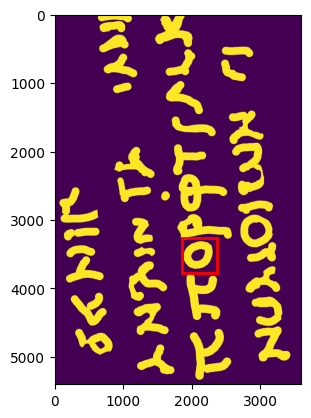

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches
rect = (1860, 3260, 512, 512)
fig, ax = plt.subplots()
ax.imshow(segment.inklabel[200:5600,1000:4600]/255)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

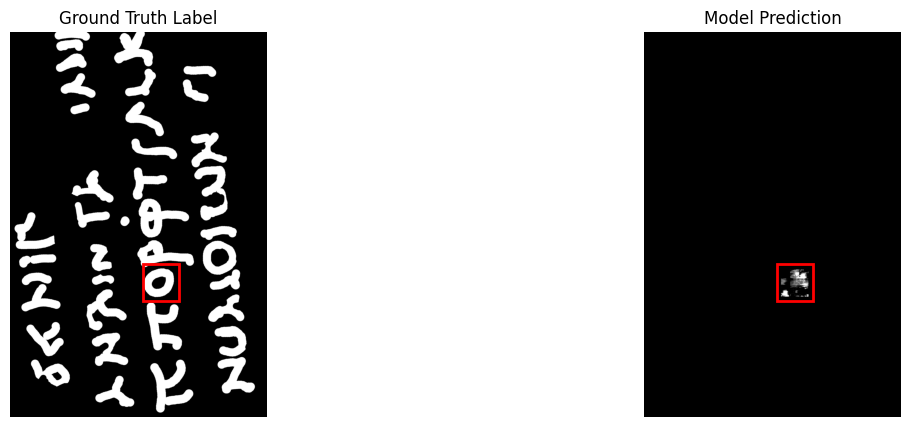

In [ ]:

# Initialize predictions and counters with the same shape as the cropped ink label segment
letter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)
counter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the model to evaluation mode
model.eval()
# Disable gradient calculations for validation to save memory and computations
with torch.no_grad():
    for batch_tiles, batch_labels, corners in valid_dataloader:
        # Move the data and labels to the GPU
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

      
        outputs = model(batch_tiles.cpu())

        # Apply sigmoid to get probabilities from logits
        predictions = torch.sigmoid(outputs)

        # Process each prediction and update the corresponding regions
        corners = corners.squeeze().cpu().numpy()
        for idx in range(corners.shape[0]):
            x_start, y_start = corners[idx, 0], corners[idx, 1]
            prediction_tile = predictions.cpu().numpy()[idx, 0]  # Convert to NumPy array
            letter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += prediction_tile
            counter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += 1

# Avoid division by zero by setting any zero counts to 1
counter_predictions[counter_predictions == 0] = 1

# Normalize the predictions by the counter values
letter_predictions /= counter_predictions

# Plotting the Ground Truth and Model Predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ground Truth Label
ax = axes[0]
ax.imshow(segment.inklabel[200:5600, 1000:4600] / 255, cmap='gray')
ax.set_title('Ground Truth Label')
ax.axis('off')

# Add a red rectangle to the ground truth plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Model Prediction
ax = axes[1]
ax.imshow(letter_predictions, cmap='gray')
ax.set_title('Model Prediction')
ax.axis('off')

# Add a red rectangle to the prediction plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Display the plots
plt.show()


Can you see the O? It's not perfect, but it is clear that the model is predicting a shape that has a hole in the middle.

We could apply many tricks to get better predictions, like implementing data augmentation, cross-validation, more sophisticated loss functions and most importantly using more data to train the model and more accurante ink labels!